# Pymaceuticals Inc.
---

### Analysis


For the entire dataset, there were roughly the same amount of datapoints collected for each treatment, and the amount of male and female mice tested were roughly equal. Capomulin seems to be a very effective treatment drug, having a lower median tumor volume than all other drugs tested except Ramicane. For the final tumor volume of each of the mice for the four most promising drugs, there was only one outlier for Infubinol that had a very low tumor volume. Based on the scatterplot for tumor size vs. weight for Capomulin, there is a correlation between tumor size and the weight of the mouse. This is backed up by the linear regression r value of 0.84. From the slope of the line, for every 1 gram increase in weight, tumor volume is predicted to increase by 0.95 mm3.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single DataFrame
study_results_df = pd.merge(study_results, mouse_metadata, how="left", on=["Mouse ID", "Mouse ID"])


# Display the data table for preview
study_results_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [2]:
# Checking the number of mice.
mice_count = len(study_results_df["Mouse ID"].unique())
mice_count

249

In [3]:
# Our data should be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
duplicate_mouse_ids = study_results_df.loc[study_results_df.duplicated(subset=['Mouse ID', 'Timepoint']),'Mouse ID'].unique()
duplicate_mouse_ids

array(['g989'], dtype=object)

In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
dup_id = study_results_df.loc[(study_results_df["Mouse ID"] == "g989"), :]
dup_id

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
#clean_results_df = study_results_df.drop_duplicates(subset=["Timepoint","Mouse ID"])

clean_results_df = study_results_df.drop(study_results_df[study_results_df["Mouse ID"] == "g989"].index)
clean_results_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [6]:
# Checking the number of mice in the clean DataFrame.
mice_count_cleaned = len(clean_results_df["Mouse ID"].unique())
mice_count_cleaned

248

## Summary Statistics

In [7]:
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.

# Grouping by treatment
regimen = clean_results_df.groupby(["Drug Regimen"])
# Finding Summary statistics
mean_vol = regimen["Tumor Volume (mm3)"].mean()
median_vol = regimen["Tumor Volume (mm3)"].median()
vol_varience = regimen["Tumor Volume (mm3)"].var()
vol_std = regimen["Tumor Volume (mm3)"].std()
vol_SE = regimen["Tumor Volume (mm3)"].sem()

# Creating Dataframe
Summary_stats_df = pd.DataFrame({
    "Mean Tumor Volume (mm3)": mean_vol,
    "Median Tumor Volume (mm3)": median_vol,
    "Varience": vol_varience,
    "Standard Deviation": vol_std,
    "Standard Error": vol_SE,
   
}) 
Summary_stats_df




,Mean Tumor Volume (mm3),Median Tumor Volume (mm3),Varience,Standard Deviation,Standard Error
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [8]:
# A more advanced method to generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen (only one method is required in the solution)
# Using the aggregation method, produce the same summary statistics in a single line


## Bar and Pie Charts

Text(0.5, 1.0, 'Rows for each Treatment')

Text(0.5, 0, 'Drug Regimen')

Text(0, 0.5, 'Number of Rows')

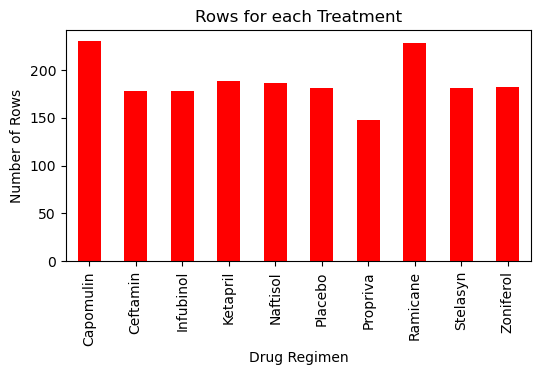

<Figure size 640x480 with 0 Axes>

In [28]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.

# Creating group 
individual_treatment_df = clean_results_df.groupby(["Drug Regimen"])

#Getting the count for each drug regimen
regimen_rows = individual_treatment_df["Mouse ID"].count()

#Creating the plot

count_chart = regimen_rows.plot(kind='bar', figsize=(6,3), color="red")
plt.title("Rows for each Treatment")
count_chart.set_xlabel("Drug Regimen")
count_chart.set_ylabel("Number of Rows")
plt.show()
plt.tight_layout()

<BarContainer object of 10 artists>

([<matplotlib.axis.XTick at 0x1c46d946d70>,
 [Text(0, 0, 'Capomulin'),
  Text(1, 0, 'Ceftamin'),
  Text(2, 0, 'Infubinol'),
  Text(3, 0, 'Ketapril'),
  Text(4, 0, 'Naftisol'),
  Text(5, 0, 'Placebo'),
  Text(6, 0, 'Propriva'),
  Text(7, 0, 'Ramicane'),
  Text(8, 0, 'Stelasyn'),
  Text(9, 0, 'Zoniferol')])

(-0.75, 9.75)

(0.0, 240.0)

Text(0.5, 1.0, 'Rows for each Treatment')

Text(0.5, 0, 'Drug Regimen')

Text(0, 0.5, 'Number of rows')

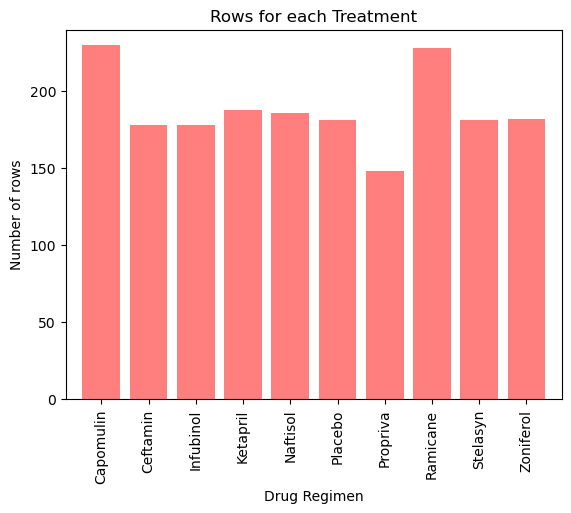

<Figure size 640x480 with 0 Axes>

In [10]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.

#getting x-axis values
total_rows = regimen_rows

# Creating list for each of the drug labels
# Had to be alphabetized to correspond with the sort
labels = clean_results_df["Drug Regimen"].unique()
labels = sorted(labels)

# Creating chart
x_axis = np.arange(len(total_rows))
plt.bar(x_axis, total_rows, color='r', alpha=0.5, align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, labels = labels, rotation=90)
plt.xlim(-0.75, len(x_axis)-0.25)
plt.ylim(0, max(total_rows)+10)
plt.title("Rows for each Treatment")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of rows")
plt.show()
plt.tight_layout()

Text(0, 0.5, 'Sex')

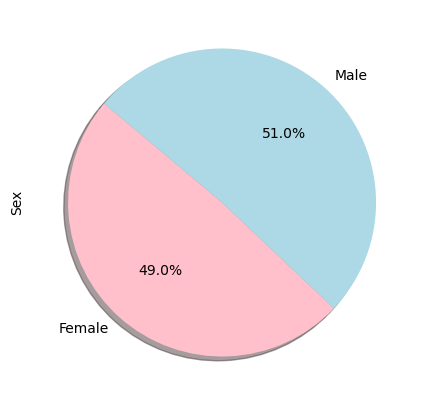

<Figure size 640x480 with 0 Axes>

In [29]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas

# Grouping by sex and finding the count
individual_sex_df = clean_results_df.groupby(["Sex"])
mice_sex = individual_sex_df["Mouse ID"].count()

# Making chart
colors = ["pink", "lightblue"]
count_chart = mice_sex.plot(kind='pie', figsize=(5,5), colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)
plt.ylabel("Sex")
plt.show()
plt.tight_layout()

([<matplotlib.patches.Wedge at 0x1c46da5c6a0>,
 [Text(-0.7320888280116858, -0.8210030133321538, 'Female'),
  Text(0.7320888280116862, 0.8210030133321533, 'Male')],
 [Text(-0.399321178915465, -0.447819825453902, '49.0%'),
  Text(0.39932117891546515, 0.4478198254539018, '51.0%')])

Text(0, 0.5, 'Sex')

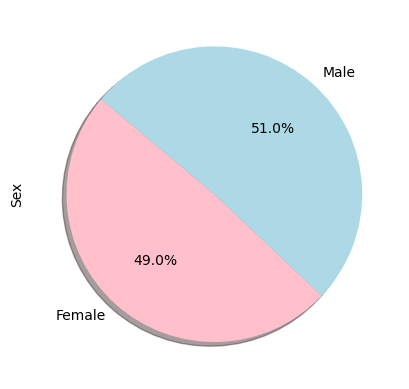

<Figure size 640x480 with 0 Axes>

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

# list for sizes of the slices
sizes = mice_sex

# Creating chart
labels = ["Female", "Male"]
colors = ["pink", "lightblue"]
explode = (.1, 0)
plt.pie(sizes, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.ylabel("Sex")
plt.show()
plt.tight_layout()

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse

last_timepoint = clean_results_df.groupby(["Mouse ID"])
last_timepoint = last_timepoint["Timepoint"].max()
last_timepoint = last_timepoint.reset_index() 

# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
results_timepoint_df = pd.merge(last_timepoint, clean_results_df,
                                 how='left', on=['Timepoint', 'Mouse ID'])
results_timepoint_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,a203,45,67.973419,2,Infubinol,Female,20,23
1,a251,45,65.525743,1,Infubinol,Female,21,25
2,a262,45,70.717621,4,Placebo,Female,17,29
3,a275,45,62.999356,3,Ceftamin,Female,20,28
4,a366,30,63.440686,1,Stelasyn,Female,16,29
...,...,...,...,...,...,...,...,...
243,z435,10,48.710661,0,Propriva,Female,12,26
244,z578,45,30.638696,0,Ramicane,Male,11,16
245,z581,45,62.754451,3,Infubinol,Female,24,25
246,z795,45,65.741070,3,Naftisol,Female,13,29


In [14]:

# Put treatments into a list for for loop (and later for plot labels)
treatment = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
# Create empty list to fill with tumor vol data (for plotting)
vol_data = []
 
# Locate the rows which contain mice on each drug and get the tumor volumes  
for drug in treatment:
    drug_filter = results_timepoint_df["Drug Regimen"] == drug
    tempvar = results_timepoint_df.loc[drug_filter,:]
    
# Resetting index so that a list can be created in subsequent steps
# Note: This cannot be done if only the Tumor volume information is located in the step above
# This is due to tempvar being a series not a dataframe if you do this
    tempvar = tempvar.reset_index() 
    
# Getting just the Tumor volumes
    tempvar = tempvar["Tumor Volume (mm3)"]
    
# Appending the tumor volumes for each drug to the list
    vol_data.append(tempvar)



In [15]:
# Set variable to count which drug from the drug list
x = 0

#Calculating summary statistics for each of the four drugs
for vol in vol_data:
    # Specifying treatment name for each vol series in voldata
    drug = treatment[x]
   
    #Find quartile values for the drug
    quartiles = vol.quantile([.25,.5,.75])
    
    #Find IQR
    lowerq = quartiles[.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    
    # Print summary stats information
    print(f"The median of {treatment[x]} is: {quartiles[0.5]} ")
    print(f"The lower quartile for {treatment[x]} is: {lowerq}")
    print(f"The upper quartile for {treatment[x]} is: {upperq}")
    print(f"The interquartile range for {treatment[x]} is: {iqr}")
    
    # Find upper and lower bounds for outliers
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    
    # Turn the data stored in each index of the volume data into its own list
    volumes_list = vol.tolist()
    
    # Determine outliers using upper and lower bounds
    for y in volumes_list:
        if y > upper_bound:     
            print(f" The volume {y} is above {upper_bound} and is an outlier for {treatment[x]}: ")
              
        if y < lower_bound:      
            print(f"The volume {y} is below {lower_bound} and is an outlier for {treatment[x]}: ")
    print("----------------------------------------------------")

    x = x+1 
    


The median of Capomulin is: 38.1251644 
The lower quartile for Capomulin is: 32.37735684
The upper quartile for Capomulin is: 40.1592203
The interquartile range for Capomulin is: 7.781863460000004
----------------------------------------------------
The median of Ramicane is: 36.56165229 
The lower quartile for Ramicane is: 31.56046955
The upper quartile for Ramicane is: 40.65900627
The interquartile range for Ramicane is: 9.098536719999998
----------------------------------------------------
The median of Infubinol is: 60.16518046 
The lower quartile for Infubinol is: 54.04860769
The upper quartile for Infubinol is: 65.52574285
The interquartile range for Infubinol is: 11.477135160000003
The volume 36.3213458 is below 36.83290494999999 and is an outlier for Infubinol: 
----------------------------------------------------
The median of Ceftamin is: 59.85195552 
The lower quartile for Ceftamin is: 48.72207785
The upper quartile for Ceftamin is: 64.29983003
The interquartile range for Ce

Text(0, 0.5, 'Final Tumor Volume (mm3)')

Text(0.5, 0, 'Capomulin')

{'whiskers': [<matplotlib.lines.Line2D at 0x1c46db76fe0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c46db77520>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c46db76e00>],
 'medians': [<matplotlib.lines.Line2D at 0x1c46db77a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c46db77d00>],
 'means': []}

Text(0.5, 0, 'Ramicane')

{'whiskers': [<matplotlib.lines.Line2D at 0x1c46dba43d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c46dba4940>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c46dba4130>],
 'medians': [<matplotlib.lines.Line2D at 0x1c46dba4e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c46dba5120>],
 'means': []}

Text(0.5, 0, 'Infubinol')

{'whiskers': [<matplotlib.lines.Line2D at 0x1c46dba56f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c46dba5c30>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c46dba5570>],
 'medians': [<matplotlib.lines.Line2D at 0x1c46dba6170>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c46dba6410>],
 'means': []}

Text(0.5, 0, 'Ceftamin')

{'whiskers': [<matplotlib.lines.Line2D at 0x1c46dba6aa0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c46dba6fe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c46dba6830>],
 'medians': [<matplotlib.lines.Line2D at 0x1c46dba7520>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c46dba77c0>],
 'means': []}

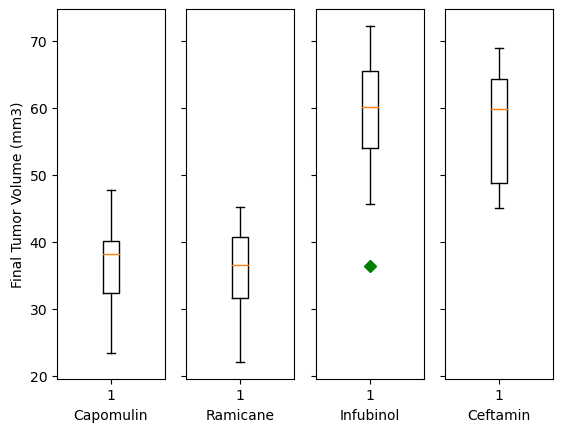

In [16]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
ax1.set_ylabel("Final Tumor Volume (mm3)")
ax1.set_xlabel(treatment[0])
ax1.boxplot(vol_data[0], 0, 'gD')

ax2.set_xlabel(treatment[1])
ax2.boxplot(vol_data[1], 0, 'gD')

ax3.set_xlabel(treatment[2])
ax3.boxplot(vol_data[2], 0, 'gD')

ax4.set_xlabel(treatment[3])
ax4.boxplot(vol_data[3], 0, 'gD')
plt.show()

## Line and Scatter Plots

<Figure size 1000x400 with 0 Axes>

Text(0.5, 14.722222222222216, 'Timepoint')

Text(91.97222222222221, 0.5, 'Tumor Volume (mm3)')

Text(0.5, 1.0, 'Tumor size over time for a single mouse treated with Capomulin')

([<matplotlib.axis.XTick at 0x1c46e8f9570>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25'),
  Text(30, 0, '30'),
  Text(35, 0, '35'),
  Text(40, 0, '40'),
  Text(45, 0, '45')])

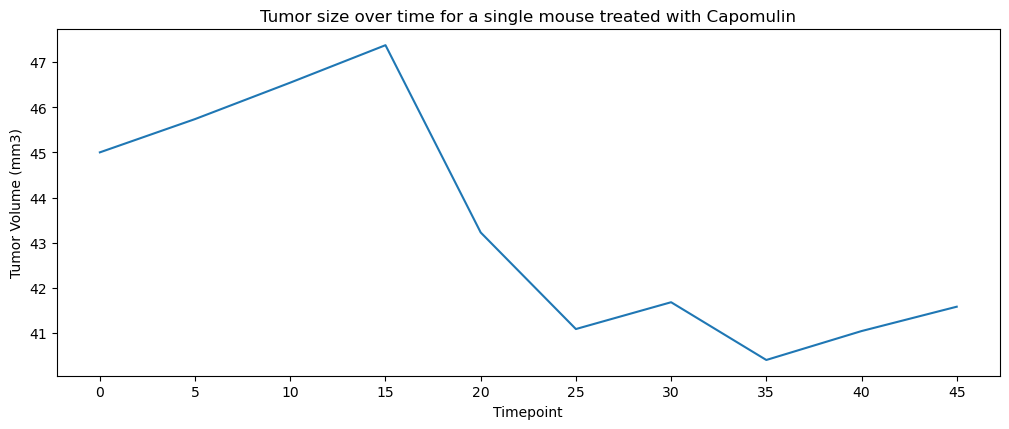

In [21]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin

# locate the data for a single mouse treated with Capomulin
#I chouse mouse r944 because it has timepoints up to 46
singmouse = clean_results_df.loc[(clean_results_df["Mouse ID"] == "r944"), :]
singmouse = singmouse[["Timepoint", "Tumor Volume (mm3)"]]

#Create plot
plt.figure(figsize=(10,4))
plt.plot(singmouse["Timepoint"], singmouse["Tumor Volume (mm3)"])
plt.tight_layout()
plt.xlabel("Timepoint") 
plt.ylabel("Tumor Volume (mm3)") 
plt.title("Tumor size over time for a single mouse treated with Capomulin") 
plt.xticks(singmouse["Timepoint"])
plt.show()

<Figure size 1000x400 with 0 Axes>

Text(0.5, 14.722222222222216, 'Weight (g)')

Text(91.97222222222221, 0.5, 'Average Tumor Volume (mm3)')

Text(0.5, 1.0, 'Average Tumor Volume vs. Weight for mice treated with Capomulin')

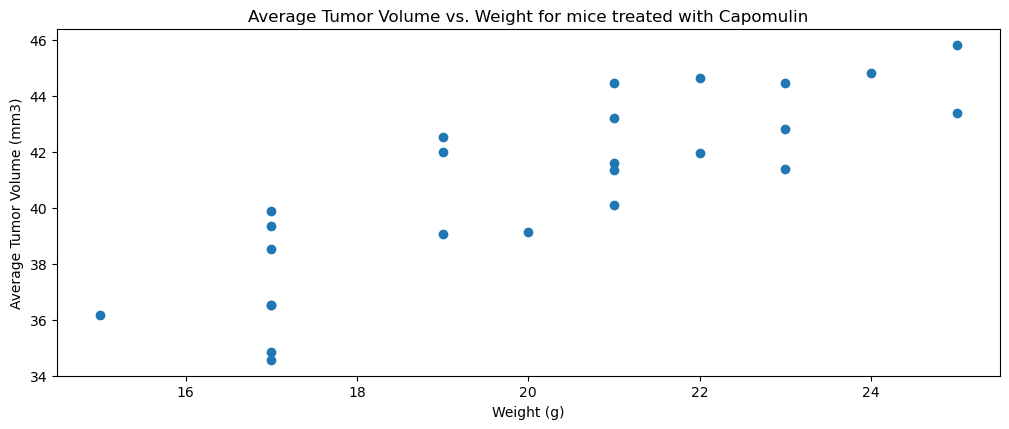

In [22]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen
#for each mouse, find the average tumor size over all time points.
# Find data for all mice on the Capomulin regimen
Capomulin = clean_results_df.loc[(clean_results_df["Drug Regimen"]== "Capomulin"), :]

# Create group based on mouse ID
grouped_capomulin = Capomulin.groupby(["Mouse ID"])

# Find average tumor volume for each mouse
avg_size = grouped_capomulin["Tumor Volume (mm3)"].mean()

# Get weight for each mouse. This works since weight does not change per timepoint
# Even if weight did change, this would still be valid since it returns mean weight over same time
weight = grouped_capomulin["Weight (g)"].mean()

# Create plot
plt.figure(figsize=(10,4))
plt.scatter(weight, avg_size,)
plt.tight_layout()
plt.xlabel("Weight (g)") 
plt.ylabel("Average Tumor Volume (mm3)") 
plt.title("Average Tumor Volume vs. Weight for mice treated with Capomulin") 
plt.show()

## Correlation and Regression

<Figure size 1000x400 with 0 Axes>

Text(0.5, 14.722222222222216, 'Weight (g)')

Text(91.97222222222221, 0.5, 'Average Tumor Volume (mm3)')

Text(0.5, 1.0, 'Average Tumor Volume vs. Weight for mice treated with Capomulin')

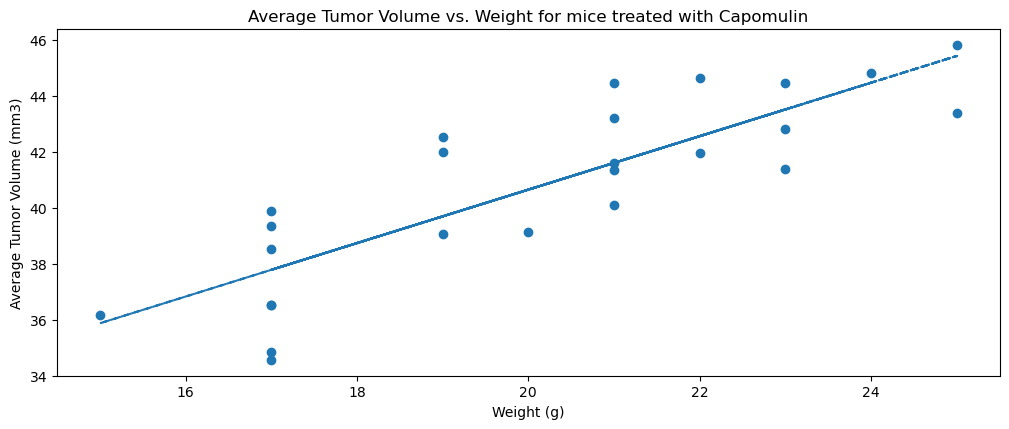

Linear regression eqn: tumor volume (mm3) = 0.9544396890241049* weight(g) + 21.552160532685008
The correlation is 0.8419363424694721


In [26]:
# Calculate the correlation coefficient and a linear regression model 
# for mouse weight and average observed tumor volume for the entire Capomulin regimen

# Generate same plot as above
plt.figure(figsize=(10,4))
plt.scatter(weight, avg_size,)
plt.tight_layout()
plt.xlabel("Weight (g)") 
plt.ylabel("Average Tumor Volume (mm3)") 
plt.title("Average Tumor Volume vs. Weight for mice treated with Capomulin") 

# Find the linear regression values using linregress function
# Unpack the results into the variables listed
r_slope, r_int, r_r, r_p, r_std_err = st.linregress(
    weight, avg_size)

# create a variable for the line equation 
r_fit = r_slope * weight + r_int

# Plot linear regression line on the graph
plt.plot(weight,r_fit,"--")
plt.show()

# Print the linear regression equation below the graph
print(f"Linear regression eqn: tumor volume (mm3) = {r_slope}* weight(g) + {r_int}")
print(f"The correlation is {r_r}")